# This is my first attempt at creating a model using sklearn alogithms
The algorithms I am most familiar with are Decision Trees and Random Forests, so that's where we'll start

In [10]:
# start with imports
import numpy as np
import pandas as pd
from pandas import DataFrame
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/mac28/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load the data from our JSON file. 
The data is stored as a dictionary of dictionaries in the json file. We store it that way beacause it's easy to add data to the existing master data file. Also, I haven't figured out how to get it in a database yet.

In [2]:
with open('/Users/mac28/CLCrawler/MasterApartmentData.json') as f:
    my_dict = json.load(f)
dframe = DataFrame(my_dict)

dframe = dframe.T
dframe

,bath,bed,cat,content,date,dog,feet,getphotos,hasmap,housingtype,lat,laundry,long,parking,price,smoking,time,wheelchair
5399866740,1,1,0,754,2016-01-12,0,750,8,0,apartment,NaN,w/d in unit,NaN,off-street parking,1400,NaN,12:22:07,NaN
5401772970,1,1,1,2632,2016-01-13,1,659,7,1,apartment,45.531,w/d in unit,-122.664,attached garage,1350,no smoking,16:24:11,wheelchair accessible
5402562933,1.5,NaN,0,1001,2016-01-14,0,1,2,1,apartment,45.5333,laundry on site,-122.709,carport,1500,no smoking,09:12:40,NaN
5402607488,1,2,0,2259,2016-01-14,0,936,12,1,condo,45.5328,w/d in unit,-122.699,attached garage,1995,NaN,09:36:16,NaN
5402822514,1,1,0,1110,2016-01-14,0,624,16,1,apartment,45.5053,w/d in unit,-122.618,street parking,1495,NaN,11:31:03,NaN
5402918870,2.5,3,0,1318,2016-01-14,0,1684,22,1,townhouse,45.602,w/d in unit,-122.667,attached garage,1800,no smoking,12:24:52,NaN
5403011764,1,1,1,1649,2016-01-14,1,750,14,1,apartment,45.5555,w/d hookups,-122.658,street parking,1340,NaN,13:19:56,NaN
5403019783,1,1,1,1324,2016-01-14,1,640,5,1,apartment,45.5198,laundry on site,-122.687,street parking,1095,no smoking,13:24:43,NaN
5403242242,1,0,1,2862,2016-01-14,1,NaN,12,1,apartment,45.5413,laundry on site,-122.676,street parking,1235,no smoking,15:54:38,NaN
5403320258,1.5,3,0,1598,2016-01-14,0,1200,17,1,house,45.4079,w/d in unit,-122.762,attached garage,1725,no smoking,16:58:11,wheelchair accessible


## Clean up the data a bit
Right now the 'shared' and 'split' are included in number of bathrooms. If I were to conver that to a number I would consider a shared/split bathroom to be half or 0.5 of a bathroom.

In [15]:
dframe.bath = dframe.bath.replace('shared',0.5)
dframe.bath = dframe.bath.replace('split',0.5)

## Get rid of null values
I haven't figured out the best way to clean this up yet. For now I'm going to drop any rows that have a null value, though I recognize that this is not a good analysis practice. We ended up dropping 2,014 data points, which is a litle less than 16% of the data. 

😬

Also there were some CRAZY outliers, and this analysis is focused on finding a model for apartments for the 99% of us that can't afford crazy extravigant apartments

In [13]:
df = dframe[dframe.price < 10000][['bath','bed','feet','price']].dropna()
df

,bath,bed,feet,price
5399866740,1,1,750,1400
5401772970,1,1,659,1350
5402607488,1,2,936,1995
5402822514,1,1,624,1495
5402918870,2.5,3,1684,1800
5403011764,1,1,750,1340
5403019783,1,1,640,1095
5403320258,1.5,3,1200,1725
5404034182,2,2,1010,1995
5404362542,1,2,850,1395


In [14]:
df.describe()

,bath,bed,feet,price
count,10602,10602,10602,10602
unique,10,7,1048,1266
top,1,1,700,995
freq,7010,3931,293,263


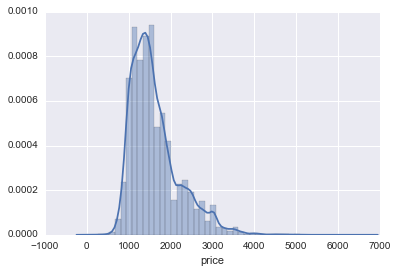

In [16]:
sns.distplot(df.price)

## Let's simplify our data
I have a hunch that bedrooms, bathrooms, and square footage have the greatest effect on housing price. Before we get too complicated, let's see how accurate we can be with just a simple set of data

In [17]:
features = df[['bath','bed','feet']].values
price = df[['price']].values

### Split data into Training and Testing Data

In [19]:
from sklearn.cross_validation import train_test_split
features_train, features_test, price_train, price_test = train_test_split(features, price, test_size=0.1, random_state=42)

In [20]:
from sklearn import tree
from sklearn.metrics import r2_score

In [21]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(features_train, price_train)

In [22]:
pred = clf.predict(features_test)
pred = np.array([[item] for item in pred])
print pred
print price_test

[[ 1552.9047619 ]
 [ 1442.04545455]
 [ 1845.        ]
 ..., 
 [ 2475.25      ]
 [ 2381.30434783]
 [ 1138.28      ]]
[[1499]
 [1400]
 [1880]
 ..., 
 [1995]
 [2350]
 [1085]]


In [23]:
r2_score(pred, price_test)

0.72255927258472008

## 72% Woot!
Wait, is that even good? I think that for the most part, it's pretty bad, but for our first run through, with super simple data, I'm willing to go with it.
## What does it look like?

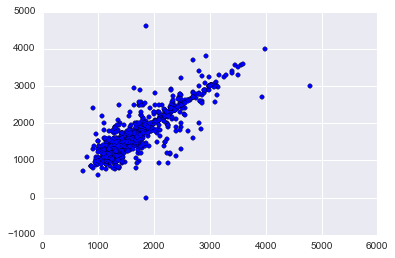

In [24]:
plt.scatter(pred,price_test)

Ok, so we can see that there's at least a relationship, which we already knew from the R^2 score.Visually it looks like there is more variation in the prices, and that we're better at predicting on the higher end, but it could very well be that we just have WAY more data on the lower end. Remember our plot from before? We see a similar thing going on

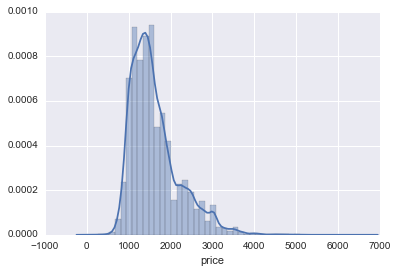

In [26]:
sns.distplot(df.price)

## Ok, so we tried decision trees. Let's try decision trees on steroids. Random Forest!

In [28]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg = reg.fit(features_train, price_train)


/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [32]:
forest_pred = reg.predict(features_test)
forest_pred = np.array([[item] for item in forest_pred])

In [30]:
r2_score(forest_pred, price_test)

0.72781788126351321

#### hmmm, it's not actually that much higher of accuracy? Maybe overfitting the data? Maybe Not enough features? Since the dataset is relatively small let's try to up the number of "Trees" that we use. We'll up it from the default 10 to 100

In [34]:
reg = RandomForestRegressor(n_estimators = 100)
reg = reg.fit(features_train, price_train)

/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [35]:
forest_pred = reg.predict(features_test)
forest_pred = np.array([[item] for item in forest_pred])

In [36]:
r2_score(forest_pred, price_test)

0.72604785095612945

##### Still no difference, ok, I can take a hint. Let's look into over-fitting

In [52]:
reg = RandomForestRegressor(min_samples_split = 20)
reg = reg.fit(features_train, price_train)

/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [53]:
forest_pred = reg.predict(features_test)
forest_pred = np.array([[item] for item in forest_pred])

In [54]:
r2_score(forest_pred, price_test)

0.63191845674939873

Shoot, we got worse. Feel free to play with it, we get better at predicting as the min samples split goes down.

# Let's try a more complicated set of data

In [56]:
df2 = dframe[dframe.price < 10000][['bath','bed','feet','dog','cat','content','getphotos', 'hasmap', 'price',]].dropna()
df2

,bath,bed,feet,dog,cat,content,getphotos,hasmap,price
5399866740,1,1,750,0,0,754,8,0,1400
5401772970,1,1,659,1,1,2632,7,1,1350
5402607488,1,2,936,0,0,2259,12,1,1995
5402822514,1,1,624,0,0,1110,16,1,1495
5402918870,2.5,3,1684,0,0,1318,22,1,1800
5403011764,1,1,750,1,1,1649,14,1,1340
5403019783,1,1,640,1,1,1324,5,1,1095
5403320258,1.5,3,1200,0,0,1598,17,1,1725
5404034182,2,2,1010,1,1,4880,19,1,1995
5404362542,1,2,850,1,1,1662,8,1,1395


In [57]:
features = df2[['bath','bed','feet','dog','cat','content','getphotos', 'hasmap']].values
price = df2[['price']].values

In [58]:
features_train, features_test, price_train, price_test = train_test_split(features, price, test_size=0.1, random_state=42)

In [59]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(features_train, price_train)

In [60]:
pred = clf.predict(features_test)
pred = np.array([[item] for item in pred])

In [61]:
r2_score(pred, price_test)

0.68162049212095055

Ahhhhh! We're just getting worse!

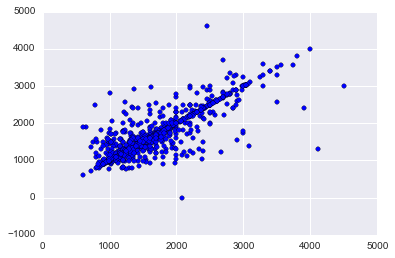

In [63]:
plt.scatter(pred,price_test)

Let's try 

In [67]:
reg = RandomForestRegressor(n_estimators=50)
reg = reg.fit(features_train, price_train)
forest_pred = reg.predict(features_test)
forest_pred = np.array([[item] for item in forest_pred])
r2_score(forest_pred, price_test)

/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


0.80036673672391367

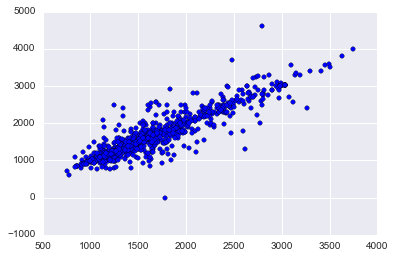

In [68]:
plt.scatter(forest_pred, price_test)

Woo! Broke 80%!!! Well, now we've reached my limit. I'm not really sure how to progress from here. Will return after learning a bit more! 

Note #1 to Riley: Next time look into another regressor? see if there's one that's inherantly better at this kind of thing.

Note #2 to Riley: Find a regressor that can take as inputs both continuous and discrete features, today we only worked with continuous

Note #3 to Riley: Clearly geography has a huge impact on housing prices. (ie. Downtown is way more expensive than the boonies.) Figure out the best way to model the effect that geography has, and then make that "multiplier" a feature in your model?